### RNN-LSTM 기반의 한국어 감정 분석기
##### 네이버 영화 리뷰(NSMC)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1. 데이터 로드

In [2]:
### 데이터 다운로드 / 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

train_data = pd.read_table('./ratings_train.txt')
test_data = pd.read_table('./ratings_test.txt')

### 2. 데이터 전처리 및 정제(1)(Train, Test)
##### 1) 중복 제거
##### 2) Null값 제거
##### 3) 한글, 공백 제외 문자 제거
##### 4) 전처리 후 Null 값 제거
##### 데이터 1차 저장(train_data_set.csv, test_data_set.csv)

In [3]:
### Data 처리
## Train Data 처리

# 1. 중복 확인/제거
train_data['document'].nunique(), train_data['label'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

# 2. Null값 처리
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

# 3. 전처리(한글과 공백 제외 문자 제거)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ? !]"," ") # 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.strip()
train_data['document'].replace('', np.nan, inplace=True)

# 4. 전처리 후 Null값 처리
train_data = train_data.dropna(how = 'any')

In [4]:
### Data 처리
## Test Data 에도 동일한 작업 수행

# 1.중복 확인/제거
test_data['document'].nunique(), test_data['label'].nunique()
test_data.drop_duplicates(subset = ['document'], inplace=True)

# 2. Null값 처리
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

# 3. 전처리(한글과 공백 제외 문자 제거)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ? !]"," ") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.strip()
test_data['document'].replace('', np.nan, inplace=True)

# 4. 전처리 후 Null값 처리
test_data = test_data.dropna(how='any') # Null 값 제거

In [5]:
### 중복, null값, 전처리(한글, 공백 제외), 전처리 후 null값 처리까지 한 데이터 저장
# Train Data
train_data.to_csv("train_data_set.csv", mode='w', index=False)

# Test Data
test_data.to_csv("test_data_set.csv", mode='w', index=False)

### 2. 데이터 전처리 및 정제(2)(Train, Test)
##### 1) 반복문자 교정
##### 2) 띄어쓰기 교정
##### 3) 맞춤법 교정
##### 데이터 2차 저장(train_last_data.csv, test_last_data.csv)

In [6]:
### 전처리 결과를 저장한 데이터 불러오기
train_data = pd.read_csv('./train_data_set.csv')
test_data = pd.read_csv('./test_data_set.csv')

In [7]:
### 데이터 정제 설정
from soynlp.normalizer import * # 반복문자 교정
from pykospacing import spacing # 띄어쓰기 교정
from hanspell import spell_checker # 맞춤법 교정           
from pandas import Series, DataFrame # 결과 저장

In [8]:
### 데이터 정제 수행 : Train Data
# 1) 반복문자 교정
# 2) 띄어쓰기 교정
# 3) 맞춤법 교정
# 4) 결과 저장

X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = repeat_normalize(sentence, num_repeats=3) # 1) 반복문자 교정
    temp_X = spacing(temp_X) # 2) 띄어쓰기 교정
    
    try:
        temp_X = spell_checker.check(temp_X).checked # 3) 맞춤법 교정
    except:
        pass

    X_train.append(temp_X)

# 4) 저장
train_last_data = pd.DataFrame({'id': train_data['id'],
                                'document': X_train,
                                'label': train_data['label']})

train_last_data.to_csv("train_last_data.csv", mode='w', index=False)

In [9]:
### 데이터 정제 수행 : Test Data
# 1) 반복문자 교정
# 2) 띄어쓰기 교정
# 3) 맞춤법 교정

X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = repeat_normalize(sentence, num_repeats=3) # 1) 반복문자 교정
    temp_X = spacing(temp_X) # 2) 띄어쓰기 교정
    
    try:
        temp_X = spell_checker.check(temp_X).checked # 3) 맞춤법 교정
    except:
        pass

    X_test.append(temp_X)

# 4) 저장
test_last_data = pd.DataFrame({'id': test_data['id'],
                                'document': X_test,
                                'label': test_data['label']})

test_last_data.to_csv("test_last_data.csv", mode='w', index=False)

### 3. 토큰화 및 불용어(Stopword) 제거(Train, Test)

In [10]:
# 저장한 데이터 불러오기!!

train_last_data = pd.read_csv('./train_last_data.csv')
test_last_data = pd.read_csv('./test_last_data.csv')

In [11]:
# 토큰화
okt = Okt()

# Stopword(불용어) 설정
stopwords = ['은','는','이','가','을','다','를','것','안','만','거','적','한','로','나','점','인','수','내','못','고','왜',
             '그','말','때','듯','요','볼','중','좀','아','뭐','네','걸','번','건','줄','년','전','저','기','지','끝','용',
             '분','데','난','라','별','알','편','야','두','또','임','여','일','면','속','애','성','엔','서','랑','제','씨',
             '냐','함','하','뿐','자','영','시','후','어','몇','눈','신','놈','감','남','준','위','살','간','명','뭔','움',
             '봄','삶','영화','에서','이가','이고','이렇다','그렇다','이렇게','그렇게']

In [12]:
# Train Data : 토큰화 및 Stopword(불용어) 제거 수행

X_train = []
for sentence in train_last_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [13]:
# Test Data : 토큰화 및 Stopword(불용어) 제거 수행

X_test = []
for sentence in test_last_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [14]:
# 실행하지 말 것.
# 임시저장
temp_train = X_train
temp_test = X_test

print(temp_train[:10])

[['더빙', '진짜', '짜증', '나다', '목소리'], ['흠', '포스터', '보고', '초등학생', '오버', '연기', '조차', '가볍다', '않다'], ['너무', '재밓었다', '그래서', '보다', '추천', '하다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이먼', '페그', '의', '익살스럽다', '연기', '돋보이다', '스파이더맨', '늙다', '보이다', '하다', '커스틴', '던스트', '너무나도', '뻐', '보이다'], ['막', '걸음', '마', '떼다', '세', '부터', '초등학교', '학년', '생인', '살다', 'ㅋㅋㅋ', '별반', '개도', '아깝다'], ['원작', '의', '긴장감', '제대로', '살리다', '하다'], ['반', '개도', '아깝다', '욕', '나오다', '음경', '길용우', '연', '생활', '인지', '정말', '발', '해도', '그것', '보단', '낫다', '납치', '감금', '반복', '반복', '드라마', '가족', '도', '없다', '연기', '하다', '사람', '모이다'], ['액션', '없다', '재미있다', '되다'], ['케', '평점', '낮다', '건데', '꽤', '할리우드', '식', '화려하다', '너무', '길들이다', '있다']]


In [17]:
# 여기서부터 다시
X_train = temp_train
X_test = temp_test

In [20]:
print(X_train[:3])
print(X_test[:3])

[['더빙', '진짜', '짜증', '나다', '목소리'], ['흠', '포스터', '보고', '초등학생', '오버', '연기', '조차', '가볍다', '않다'], ['너무', '재밓었다', '그래서', '보다', '추천', '하다']]
[['굳다', 'ㅋ'], ['평점', '들', '나쁘다', '않다', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '돈', '주다', '보기', '에는']]


### 4. 정수 인코딩

In [21]:
### 정수 인코딩
## Train Data
# 단어 집합 생성

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
#print(tokenizer.word_index)


## 단어 비중 확인
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

## key, value = 단어와 빈도수의 쌍(pair)
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 35165
등장 빈도가 2번 이하인 희귀 단어의 수: 17552
단어 집합에서 희귀 단어의 비율: 49.91326603156548
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5020675660927245


In [22]:
## 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2

print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 17615


In [23]:
## 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [24]:
## Train, Test Data 정답(label)
y_train = np.array(train_last_data['label'])
y_test = np.array(test_last_data['label'])

### 5. 빈 샘플(Empty) 제거

In [26]:
### 빈 샘플(Empty) 제거
# 각 샘플들의 길이를 확인
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 길이=0인 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

### 6. 패딩

리뷰의 최대 길이 : 129
리뷰의 평균 길이 : 10.223316551073399


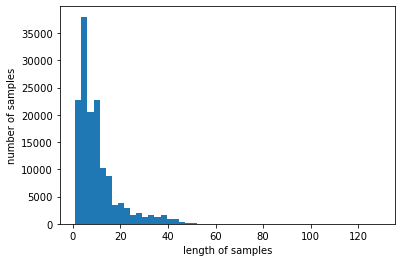

In [27]:
### 동일한 길이로 패딩
# 전체 데이터의 길이에 대한 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율 확인
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [29]:
# 동일한 길이 설정을 위한 전체에 대한 비율 확인
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.81999820928007


In [30]:
# 모두 동일한 길이로 설정(max_len)
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 7. LSTM 모델 설정 및 학습/평가

In [45]:
### LSTM 모델 설정
#from keras.layers import GRU, LSTM, CuDNNGRU, CuDNNLSTM, Activation
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(Embedding(vocab_size, 128, input_length=max_len))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('nsmc_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [46]:
### Model 학습 및 생성
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=128, validation_split=0.2)

Epoch 1/15
907/908 [============================>.] - ETA: 0s - loss: 0.4239 - acc: 0.8079
Epoch 00001: val_acc improved from -inf to 0.83718, saving model to nsmc_best_model.h5
908/908 [==============================] - 64s 70ms/step - loss: 0.4238 - acc: 0.8079 - val_loss: 0.3706 - val_acc: 0.8372
Epoch 2/15
907/908 [============================>.] - ETA: 0s - loss: 0.3622 - acc: 0.8442
Epoch 00002: val_acc improved from 0.83718 to 0.84232, saving model to nsmc_best_model.h5
908/908 [==============================] - 64s 70ms/step - loss: 0.3622 - acc: 0.8442 - val_loss: 0.3603 - val_acc: 0.8423
Epoch 3/15
907/908 [============================>.] - ETA: 0s - loss: 0.3406 - acc: 0.8553
Epoch 00003: val_acc improved from 0.84232 to 0.84438, saving model to nsmc_best_model.h5
908/908 [==============================] - 63s 70ms/step - loss: 0.3406 - acc: 0.8553 - val_loss: 0.3542 - val_acc: 0.8444
Epoch 4/15
907/908 [============================>.] - ETA: 0s - loss: 0.3273 - acc: 0.8631


In [47]:
### 생성된 모델 평가
loaded_model = load_model('nsmc_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 8s 6ms/step - loss: 0.3457 - acc: 0.8484

 테스트 정확도: 0.8484


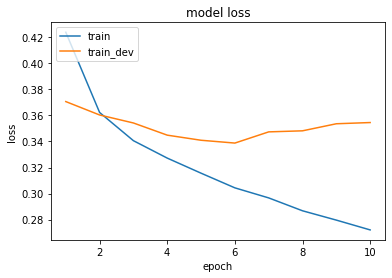

In [48]:
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'train_dev'], loc='upper left')
plt.show()

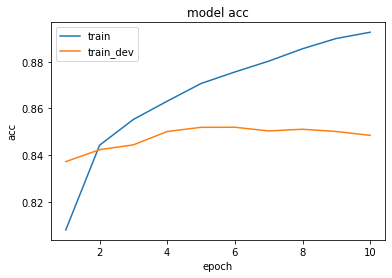

In [49]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'train_dev'], loc='upper left')
plt.show()

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [51]:
predictions = model.predict(X_test)
predictions

array([[0.9779589 ],
       [0.5806041 ],
       [0.04059622],
       ...,
       [0.9198279 ],
       [0.00225395],
       [0.17061722]], dtype=float32)

In [52]:
y_pred = (predictions > 0.5)
cf = confusion_matrix(y_test, y_pred)

In [53]:
df_cm = DataFrame(cf, index=[i for i in "10"], columns= [i for i in "10"])
df_cm

,1,0
1,20123,4209
0,3330,21190


<AxesSubplot:title={'center':'confusion matrix without confusion'}>

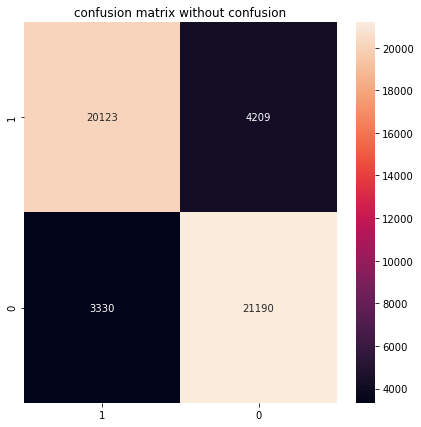

In [55]:
plt.figure(figsize = (7,7))
plt.title('confusion matrix without confusion')
sns.heatmap(df_cm, annot=True, fmt='d')

### Private Data 평가 실행

In [91]:
def sentiment_predict(new_sentence):
    
    new_sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", " ", new_sentence) # 전처리(한글, 공백 제외한 문자 제거)
    new_sentence = repeat_normalize(new_sentence, num_repeats=1) # 반복 문자
    new_sentence = spacing(new_sentence) # 띄어쓰기
    
    try:
        new_sentence = spell_checker.check(new_sentence).checked # 맞춤법 교정
    except:
        pass
    
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    
    result = 0  
    
    if(score > 0.5):
        result = 1
    else:
        result = 0
    return result

In [92]:
eval_data = pd.read_csv('./ko_data.csv', engine='python', encoding='utf-8')
eval_data['Predicted'] = 0

for i in range(len(eval_data)):
    Predicted = sentiment_predict(eval_data['Sentence'][i])
    eval_data['Predicted'][i] = Predicted
    
eval_data.drop(['Sentence'], axis='columns', inplace=True)
eval_data.to_csv("result_2019512014_이동환.csv", index=False)

<ipython-input-92-22aef0de803e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_data['Predicted'][i] = Predicted
